In [1]:
import numpy as np
import matplotlib.pyplot as plt
from jax import numpy as jnp, random, vmap, grad, value_and_grad, jit
import matplotlib.pyplot as plt
import qujax
import jax
import numpy as np

In [4]:
def digit_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return x

def binary_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return unpacknbits(x[:,None], num_bit).reshape((-1,)+geometry)

def unpacknbits(arr, nbit, axis=-1):
    '''unpack numbers to bitstrings.'''
    nd = np.ndim(arr)
    if axis < 0:
        axis = nd + axis
    return (((arr & (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1)))) > 0).astype('int8')


def packnbits(arr, axis=-1):
    '''pack bitstrings to numbers.'''
    nd = np.ndim(arr)
    nbit = np.shape(arr)[axis]
    if axis < 0:
        axis = nd + axis
    return (arr * (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1))\
           ).sum(axis=axis, keepdims=True).astype('int')

def gaussian_pdf(geometry, mu, sigma):
    '''get gaussian distribution function'''
    x = digit_basis(geometry)
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * \
        np.exp(-(x - mu)**2 / (2. * sigma**2))
    return pl/pl.sum()


def barstripe_pdf(geometry):
    '''get bar and stripes PDF'''
    x = binary_basis(geometry)
    pl = is_bs(x)
    return pl/pl.sum()

def is_bs(samples):
    '''a sample is a bar or a stripe.'''
    return (np.abs(np.diff(samples,axis=-1)).sum(axis=(1,2))==0\
           )|((np.abs(np.diff(samples, axis=1)).sum(axis=(1,2)))==0)

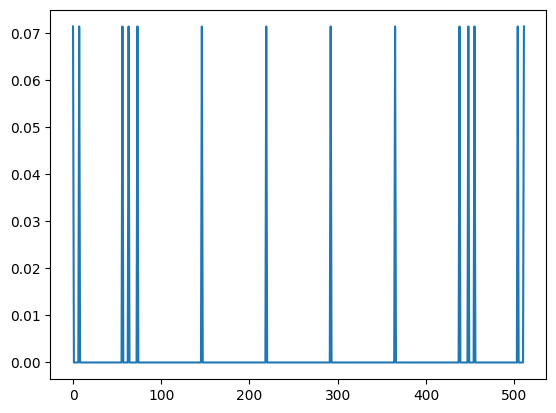

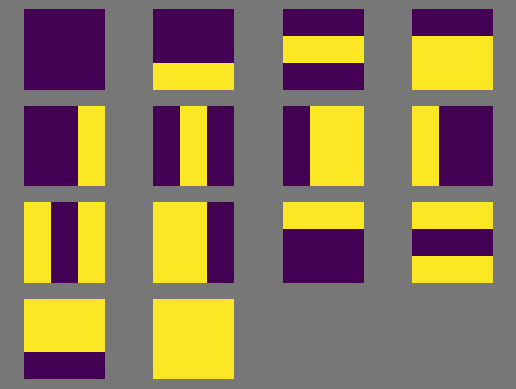

In [42]:
geometry = (3,3)
pl2 = barstripe_pdf(geometry)
plt.plot(pl2)

basis = binary_basis(geometry)

# generate samples
samples = basis[pl2>1e-2]

# show bar and stripes
def plot_bs(samples, size):
    plt.figure(facecolor='#777777')
    gs = plt.GridSpec(*size)

    for i in range(size[0]):
        for j in range(size[1]):
            if i*size[1]+j == len(samples): break
            plt.subplot(gs[i,j]).imshow(samples[i*size[1]+j], vmin=0, vmax=1)
            plt.axis('equal')
            plt.axis('off')
    plt.show()

size = (4, 4)
plot_bs(samples, size)

In [6]:
n_qubits = 8
circuit_depth = 3
init_rad = 0.001 / jnp.pi
beta = 1e3
get_stepsize = lambda step: (step + 10) ** (-1 / 3)
n_steps = 5000
random_key = random.PRNGKey(0)
init_key, train_key = random.split(random_key)
data = jax.device_put(samples)

In [7]:
samples = np.random.multivariate_normal(np.array([0., 0.]), np.eye(2), 14)
data = jax.device_put(samples)

In [ ]:
def expected_kernel(kernel, data1, weights1, data2, weights2):
    def row_eval(data1_single):
        return (vmap(kernel, in_axes=(None, 0))(data1_single, data2) * weights2).sum()

    return (vmap(row_eval)(data1) * weights1).sum()

def mmd(kernel, data1, weights1, data2, weights2):
    return (
        expected_kernel(kernel, data1, weights1, data1, weights1)
        - 2 * expected_kernel(kernel, data1, weights1, data2, weights2)
        + expected_kernel(kernel, data2, weights2, data2, weights2)
    )

def get_circuit(n_qubits, depth):
    n_params = 2 * n_qubits * (depth + 1)

    gates = ["H"] * n_qubits + ["Rx"] * n_qubits + ["Ry"] * n_qubits
    qubit_inds = [[i] for i in range(n_qubits)] * 3
    param_inds = [[]] * n_qubits + [[i] for i in range(n_qubits * 2)]

    k = 2 * n_qubits

    for _ in range(depth):
        for i in range(0, n_qubits - 1):
            gates.append("CZ")
            qubit_inds.append([i, i + 1])
            param_inds.append([])
        for i in range(n_qubits):
            gates.append("Rx")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
        for i in range(n_qubits):
            gates.append("Ry")
            qubit_inds.append([i])
            param_inds.append([k])
            k += 1
    return gates, qubit_inds, param_inds, n_params

gates, qubit_inds, param_inds, n_params = get_circuit(n_qubits, circuit_depth)
qujax.print_circuit(gates, qubit_inds, param_inds, gate_ind_max=48);

param_to_st = qujax.get_params_to_statetensor_func(gates, qubit_inds, param_inds)
dist_mat = vmap(lambda a: vmap(lambda b: (a - b) ** 2)(data))(data)
bandwidth_sq = jnp.median(dist_mat) / 2


def gaussian_kernel(s1, s2):
    return jnp.exp(-jnp.square(jnp.linalg.norm(s1 - s2)) / bandwidth_sq)

data_probs = jnp.ones(len(data)) / len(data)

def param_to_mmd(param):
    st = param_to_st(param)
    probs = jnp.square(jnp.abs(st.flatten()))
    return mmd(gaussian_kernel, jnp.arange(st.size), probs, data, data_probs)

param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
)
train_keys = random.split(train_key, n_steps - 1)
params = jnp.zeros((n_steps, n_params))
params = params.at[0].set(init_param)

cost_vals = jnp.zeros(n_steps - 1)

M, M_inv, mu_inv, N_d, kBT, sigma, sigma_a = jnp.eye(n_params), jnp.eye(n_params), 1., 1., 1/beta, 1., 1.

### Training with SGLD

In [ ]:
param_to_mmd_and_grad = jit(value_and_grad(param_to_mmd))
init_param = random.uniform(
    init_key, shape=(n_params,), minval=-init_rad, maxval=init_rad
)
train_keys = random.split(train_key, n_steps - 1)
params = jnp.zeros((n_steps, n_params))
params = params.at[0].set(init_param)

cost_vals = jnp.zeros(n_steps - 1)

for step in range(1, n_steps):
    cost_val, cost_grad = param_to_mmd_and_grad(params[step - 1])
    cost_vals = cost_vals.at[step - 1].set(cost_val)

    stepsize = get_stepsize(step)

    new_param = (
            params[step - 1]
            - stepsize * cost_grad
            + jnp.sqrt(2 * stepsize / beta)
            * random.normal(train_keys[step - 1], shape=(n_params,))
    )
    params = params.at[step].set(new_param)

    print("Iteration:", step, "\tCost:", cost_val, end="\r")

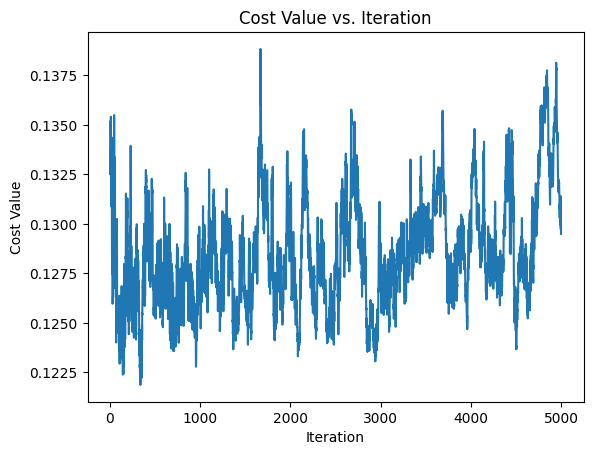

In [25]:
# Plot the cost values
plt.figure()
plt.plot(range(1, n_steps), cost_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost Value")
plt.title("Cost Value vs. Iteration")
plt.show()

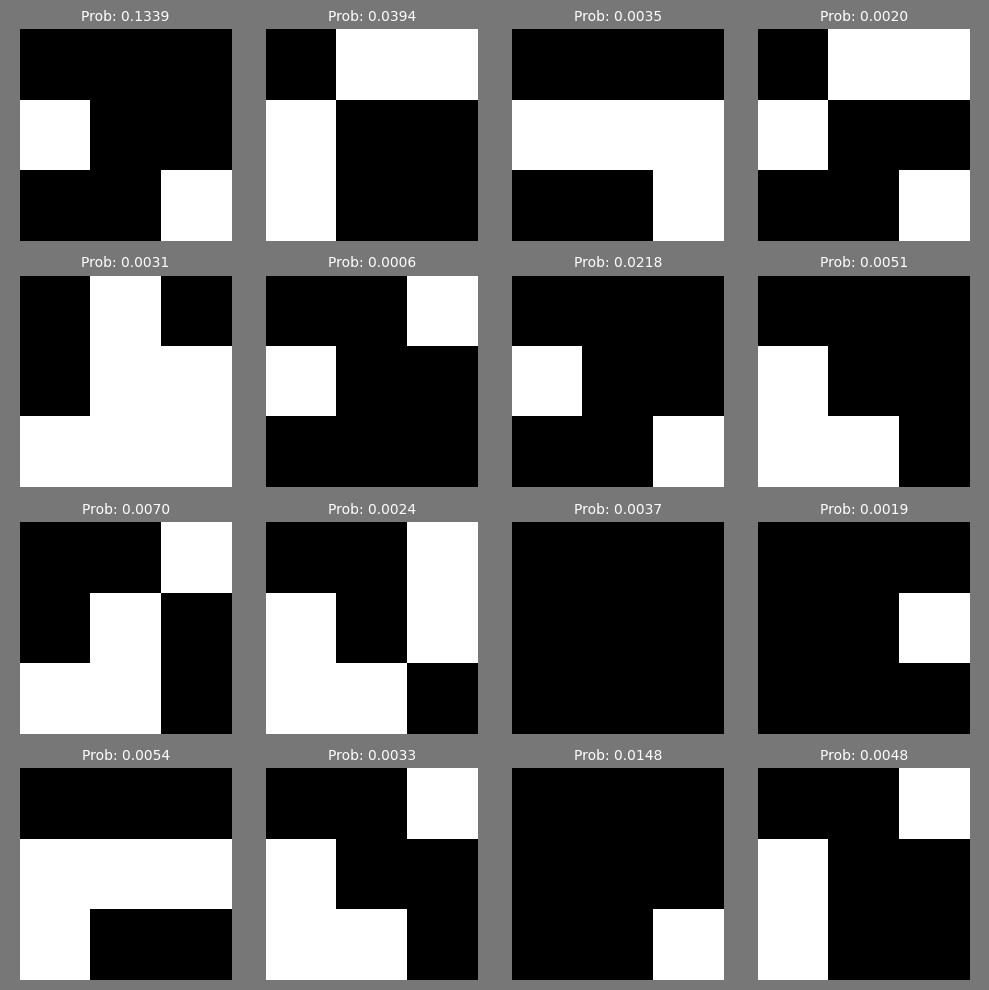

In [31]:
# Get the index of the minimum cost value
min_cost_idx = np.argmin(cost_vals)

# Get the final parameters corresponding to the minimum cost
final_params = params[min_cost_idx + 1] 

def plot_bs(samples, size, probabilities):
    plt.figure(figsize=(10, 10), facecolor='#777777')
    gs = plt.GridSpec(*size)

    for i in range(size[0]):
        for j in range(size[1]):
            if i * size[1] + j == len(samples):
                break
            ax = plt.subplot(gs[i, j])
            ax.imshow(samples[i * size[1] + j], vmin=0, vmax=1, cmap='gray')
            ax.axis('equal')
            ax.axis('off')
            ax.set_title(f"Prob: {probabilities[i * size[1] + j]:.4f}", fontsize=10, color='white')

    plt.tight_layout()
    plt.show()

# Function to convert state index to binary representation and reshape
def index_to_image(index, geometry):
    # Convert the index to binary format
    binary_string = format(index, f'0{np.prod(geometry)}b')

    # Convert the binary string to an array of integers and then reshape it according to the geometry
    return np.array([int(bit) for bit in binary_string]).reshape(geometry)

# Generating samples from the final parameters
def generate_samples_from_final_params(final_params, geometry, num_samples=10):
    # Generate the state tensor from the final parameters
    final_st = param_to_st(final_params)

    # Calculate probabilities (squared magnitudes of the state tensor elements)
    probabilities = jnp.square(jnp.abs(final_st.flatten()))

    # Convert probabilities to a numpy array for use with numpy's random.choice
    probabilities_np = np.array(probabilities)

    # Sample state indices according to the probabilities
    sampled_indices = np.random.choice(len(probabilities_np), size=num_samples, p=probabilities_np)

    # Convert indices to binary images
    samples = np.array([index_to_image(idx, geometry) for idx in sampled_indices])

    return samples

# Set the geometry and the number of samples you want
geometry = (3, 3)
num_samples = 16  # For a 4x4 grid visualization

# Generate samples from the final parameters
final_samples = generate_samples_from_final_params(final_params, geometry, num_samples)

# Get the corresponding probabilities
final_st = param_to_st(final_params)
probabilities = jnp.square(jnp.abs(final_st.flatten()))
probabilities_np = np.array(probabilities)

# Visualize the generated samples with probabilities
plot_bs(final_samples, size=(4, 4), probabilities=probabilities_np)

### Training with SGNHT

In [37]:
def G(p):
  return mu_inv * (p.T @ M_inv @ p - N_d * kBT)

def A_step(q,p,xi,h):
  q = q + h * M_inv @ p
  return q,p,xi

def B_step(q,p,xi,h,force):
  p = p + h * (force(q) + sigma * np.sqrt(M) @ np.random.randn(p.shape[0]))
  return q,p,xi

def O_step(q,p,xi,h):
  term1 = np.exp(-xi*h) * p
  term2 = sigma_a * np.sqrt((1 - np.exp(-2 * xi * h)) / (2 * xi)) * np.random.randn(p.shape[0])
  p = term1 + term2
  return q,p,xi

def D_step(q,p,xi,h):
  xi = xi + h * G(p)
  return q,p,xi

def ld_BADODAB(q,p,xi,h,force):

    q, p, xi = np.copy(q), np.copy(p), np.copy(xi)
    q, p, xi = B_step(q,p,xi,h/2,force)
    q, p, xi = A_step(q,p,xi,h/2)
    q, p, xi = D_step(q,p,xi,h/2)
    q, p, xi = O_step(q,p,xi,h)
    q, p, xi = D_step(q,p,xi,h/2)
    q, p, xi = A_step(q,p,xi,h/2)
    q, p, xi = B_step(q,p,xi,h/2,force)

    return q, p, xi

def run_simulation(q0, p0, xi0, Nsteps, h, step_function, force):

    q_traj = [q0]
    p_traj = [p0]
    xi_traj = [xi0]
    cost_vals = []

    q = q0
    p = p0
    xi = xi0

    for n in range(Nsteps):
        cost_val, cost_grad = param_to_mmd_and_grad(q_traj[n - 1])
        q,p,xi = step_function(q, p, xi, h, force)
        cost_vals.append(cost_val)

        q_traj.append([q])
        p_traj.append([p])
        xi_traj.append([xi])

    return q_traj, p_traj, xi_traj, cost_vals

In [38]:
params, p_traj, xi_traj, cost_vals = run_simulation(params[0], np.random.randn(n_params), 0.0, n_steps, 0.1, ld_BADODAB, lambda q: -param_to_mmd_and_grad(q)[1])

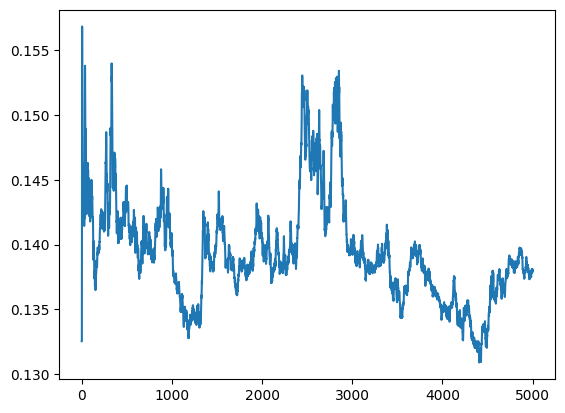

In [39]:
plt.plot(np.arange(1,n_steps+1), cost_vals)

(array([80., 59., 38., 11., 16.,  8., 11.,  7.,  3.,  3.,  5.,  2.,  4.,
         1.,  2.,  2.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  1.]),
 array([6.09367180e-06, 1.20926974e-03, 2.41244584e-03, 3.61562171e-03,
        4.81879804e-03, 6.02197368e-03, 7.22514978e-03, 8.42832588e-03,
        9.63150151e-03, 1.08346781e-02, 1.20378537e-02, 1.32410303e-02,
        1.44442059e-02, 1.56473815e-02, 1.68505590e-02, 1.80537347e-02,
        1.92569103e-02, 2.04600859e-02, 2.16632616e-02, 2.28664391e-02,
        2.40696147e-02, 2.52727903e-02, 2.64759660e-02, 2.76791416e-02,
        2.88823191e-02, 3.00854947e-02, 3.12886722e-02, 3.24918479e-02,
        3.36950235e-02, 3.48981991e-02, 3.61013748e-02]),
 <BarContainer object of 30 artists>)

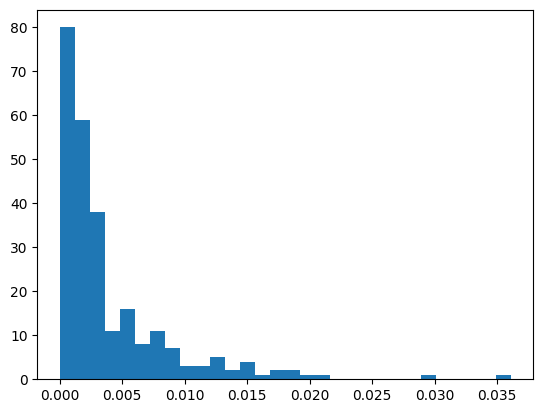

In [40]:
final_params = params[np.argmin(cost_vals)]
final_st = param_to_st(final_params)
plt.hist(jnp.square(jnp.abs(final_st.flatten())), bins = 30)

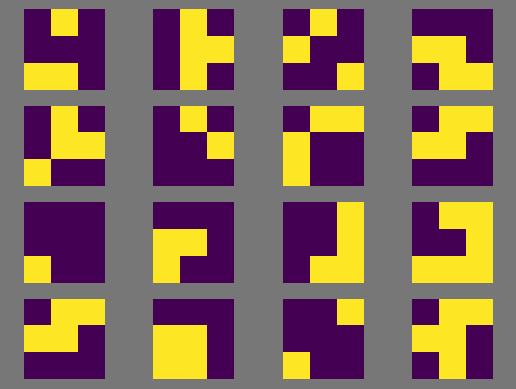

In [43]:
# Function to convert state index to binary representation and reshape
def index_to_image(index, geometry):
    # Convert the index to binary format
    binary_string = format(index, f'0{np.prod(geometry)}b')
    # Convert the binary string to an array of integers and then reshape it according to the geometry
    return np.array([int(bit) for bit in binary_string]).reshape(geometry)

# Generating samples from the final parameters
def generate_samples_from_final_params(final_params, geometry, num_samples=10):
    # Generate the state tensor from the final parameters
    final_st = param_to_st(final_params)
    # Calculate probabilities (squared magnitudes of the state tensor elements)
    probabilities = jnp.square(jnp.abs(final_st.flatten()))
    # Convert probabilities to a numpy array for use with np.random.choice
    probabilities_np = np.array(probabilities)
    # Sample state indices according to the probabilities
    sampled_indices = np.random.choice(len(probabilities_np), size=num_samples, p=probabilities_np)
    # Convert indices to binary images
    samples = np.array([index_to_image(idx, geometry) for idx in sampled_indices])
    return samples

# Set the geometry and the number of samples you want
geometry = (3, 3)
num_samples = 16 

# Generate samples from the final parameters
final_samples = generate_samples_from_final_params(final_params, geometry, num_samples)

# Visualize the generated samples
plot_bs(final_samples, size=(4, 4))

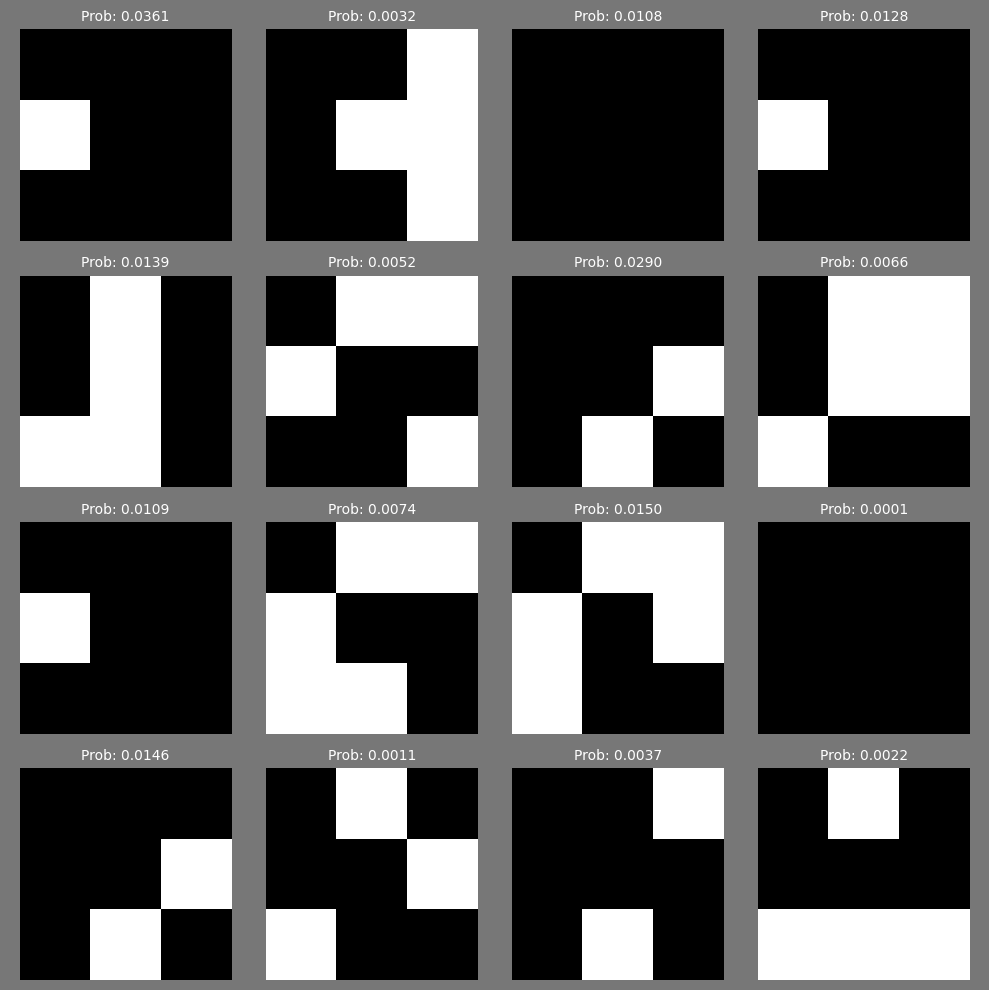

In [44]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bs(samples, probabilities, size):
    plt.figure(figsize=(10, 10), facecolor='#777777')
    gs = plt.GridSpec(*size)

    for i in range(size[0]):
        for j in range(size[1]):
            ax = plt.subplot(gs[i, j])
            if i * size[1] + j < len(samples):
                ax.imshow(samples[i * size[1] + j], vmin=0, vmax=1, cmap='gray')
                ax.axis('equal')
                ax.axis('off')
                ax.set_title(f"Prob: {probabilities[i * size[1] + j]:.4f}", fontsize=10, color='white')
            else:
                ax.axis('off')

    plt.tight_layout()
    plt.show()

# Function to convert state index to binary representation and reshape
def index_to_image(index, geometry):
    # Convert the index to binary format
    binary_string = format(index, f'0{np.prod(geometry)}b')

    # Convert the binary string to an array of integers and then reshape it according to the geometry
    return np.array([int(bit) for bit in binary_string]).reshape(geometry)

# Generating samples from the final parameters
def generate_samples_from_final_params(final_params, geometry, num_samples=10):
    # Generate the state tensor from the final parameters
    final_st = param_to_st(final_params)

    # Calculate probabilities (squared magnitudes of the state tensor elements)
    probabilities = jnp.square(jnp.abs(final_st.flatten()))

    # Convert probabilities to a numpy array for use with numpy's random.choice
    probabilities_np = np.array(probabilities)

    # Sample state indices according to the probabilities
    sampled_indices = np.random.choice(len(probabilities_np), size=num_samples, p=probabilities_np)

    # Convert indices to binary images
    samples = np.array([index_to_image(idx, geometry) for idx in sampled_indices])

    return samples, probabilities_np

# Set the geometry and the number of samples you want
geometry = (3, 3)
num_samples = 16  # For a 4x4 grid visualization

# Generate samples from the final parameters
final_samples, final_probabilities = generate_samples_from_final_params(final_params, geometry, num_samples)

# Visualize the generated samples with probabilities
plot_bs(final_samples, final_probabilities, size=(4, 4))